# Lecture 2. CUDA memory model.

In this lecture, we will focus on the memory hierarchy in NVIDIA GPU CUDA-enabled cards. Memory access is often a significant part of GPU kernel execution time, so choosing the right type of memory for the task at hand often plays a key role.

During the exercises, we will learn how to use selected types of memory and what are their advantages and limitations:

1. global memory,
2. shared memory,
3. constant memory.

In this and the following notebooks, we will use the tools, tests and benchmarks available in the `gpu_short_course` Python package, which can be found in the repository https://github.com/us4useu/ius-2021-gpu-short-course. Please run the below line before proceeding:

In [1]:
! pip install --upgrade --force-reinstall git+https://github.com/pjarosik/ius-2021-gpu-short-course.git

  Cloning https://github.com/pjarosik/ius-2021-gpu-short-course.git to /tmp/pip-req-build-82160qmp
  Running command git clone -q https://github.com/pjarosik/ius-2021-gpu-short-course.git /tmp/pip-req-build-82160qmp
  Created wheel for gpu-short-course: filename=gpu_short_course-0.0.1-cp37-none-any.whl size=3118 sha256=22e5a1c1298adedcb5de723c60ecaa8e517d7c61de2f883af1ff9f7c449aa4a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-0qy67dnp/wheels/d7/84/a4/665230ffafebdbb585e899b8bda26dfd99956bb521296ec94e
Successfully built gpu-short-course
  Found existing installation: gpu-short-course 0.0.1
    Uninstalling gpu-short-course-0.0.1:
      Successfully uninstalled gpu-short-course-0.0.1


Then, let's we do all the necessary imports:

In [2]:
import math
from numba import cuda, float32, int32
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import gpu_short_course
import cupy as cp

GPU:0: b'Tesla T4'


## Exercise 2.1. One-dimensional convolution, global memory.

### Exercise 2.1.1. Convolution on CPU.

In this and subsequent notebooks, we will focus on the implementation and optimization of 1D convolution. The convolution operator has very broad applications, that also include signal and image processing, signal filtering in particular.

We will use the following definition of of the discrete convolution operator:

\begin{equation*}
y[i] = (x \ast h)[i] = \sum_{j=0}^{N-1} x[i+o-j]h[j] 
\end{equation*}

where:
- $x$ is an input signal samples, i.e. a vector of samples, $x[k]$ is equal 0 for $k < 0$, 
- $h$ is the impulse response of the filter, a vector of $N$ samples,
- $o$ is the initial offset of convolution operation.

We assume that the length $x$ is not less than $h$, for the sake of simplicity. 

Signal filtration is realised by convolving the signal with impulse response of the filter.

The constant $o$ allows us to choose the input sample, where the filtering starts. During the course will assume the following:

\begin{equation*}
o = \left\lceil \frac{N}{2} \right\rceil-1
\end{equation*}

The offset corresponds to the `mode='full'` in the [`numpy.convolve`](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) function. 

Example:
```
x = [0, 1, 2, 3, 4]
h = [0, 1, 2]
```

For given input parameters, input offset will be equal to `1`. So, the output signal will be equal:
```
y[0] = h[0]*x[1]+h[1]*x[0]           = 0
y[1] = h[0]*x[2]+h[1]*x[1]*h[2]*x[0] = 1
y[2] = h[0]*x[3]+h[1]*x[2]*h[2]*x[1] = 4
y[3] = h[0]*x[4]+h[1]*x[3]+h[2]*x[2] = 7
y[4] = h[1]*x[4]+h[2]*x[3]           = 10
```

This corresponds to moving the filter window as follows:
```
 x = [0, 1, 2, 3, 4]      y = 
     [1, 0]               [0 ]
     [2, 1, 0]            [1 ]
        [2, 1, 0]         [4 ]
           [2, 1, 0]      [7 ]
              [2, 1]      [10]
```

Now we will implement a baseline version of the convolution, first on CPU:

In [3]:
def convolve_cpu(x, h):
    # Get constants and 
    M = len(x)
    N = len(h)
    y = np.zeros(M, dtype=x.dtype)
    o = int(math.ceil(N/2)-1)
        
    # For each output sample.
    for i in range(M):
        value = 0.0
        # For each filter's coefficient.
        for j in range(N):
            k = i+o-j    
            if k >= 0 and k < M:
                value += x[k]*h[j]
        y[i] = value
    return y


convolve_cpu(np.array([0, 1, 2, 3, 4]), 
             np.array([0, 1, 2]))

array([ 0,  1,  4,  7, 10])

Now let's check how the `convolve_cpu` function works in filtering less trivial signals. First, we will prepare an artificially noisy signal:

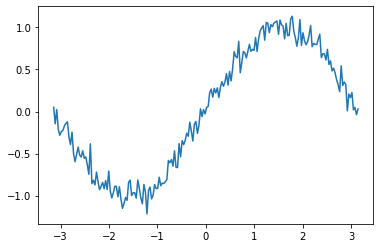

In [4]:
t = np.linspace(-math.pi, math.pi, 200)
noisy_signal = np.sin(t) + 0.1*np.random.randn(len(t))
plt.plot(t, noisy_signal)

We will use a [moving average filter](https://en.wikipedia.org/wiki/Moving_average) to remove the (artifically) added noise the the input signal. The moving average filter is simply a vector of $\frac{1}{N}$ values, where $N$ is the size of the filter. 

In [5]:
N = 64
ma_filter = np.ones(N)/N

Finally, let's do the actual filtering:

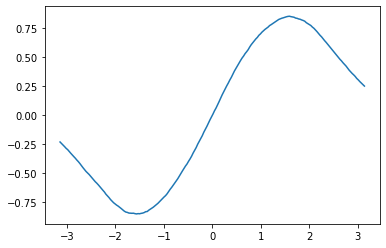

In [6]:
denoised_signal = convolve_cpu(noisy_signal, ma_filter)
plt.plot(t, denoised_signal)

For the purpose of this course we have prepared two functions that checks correctness and performance: 
- `gpu_short_course.tests.test_convolve`: performs validation tests on the passed convolve function,
- `gpu_short_course.tests.benchmark_convolve`: measures the average execution time of the passed function on random data. 

Let's check if the function passes the tests prepared for this course:

In [7]:
gpu_short_course.tests.test_convolve(convolve_cpu)

All tests passed.


If everything is OK, you should see `All tests passed.`

Now, let's see how fast the CPU implementation is:


In [8]:
gpu_short_course.tests.benchmark_convolve(convolve_cpu, x_size=2^14, n=1)

Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0006 seconds (+/- 0.0000), median: 0.0006


In [9]:
gpu_short_course.tests.benchmark_convolve(lambda x, h: np.convolve(x, h, mode='same'), n=10)

Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0390 seconds (+/- 0.0026), median: 0.0387


### Exercise 2.1.2. Convolution on GPU.

Now let's check how much performance gain we get by moving the calculations on the GPU.

As we did in the previous lecture, let's we decicate each GPU thread to compute a single output sample. In other words, each GPU thread should execute body of the `convolve_cpu`'s outer loop, i.e. lines 10-16.

In [10]:
@cuda.jit
def convolve_gpu_kernel(y, x, h):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x

    M = len(x)
    N = len(h)
    o = int(math.ceil(N/2)-1)
    
    if i >= len(y):
        return
    
    # We explicitly cast the 0.0 value to float32, to be
    # sure we operate on 32-bit floating point numbers.
    value = float32(0.0)

    # Does the below looks familiar? 
    # It is almost copy-and-paste from the 
    # convolve_cpu function.
    for j in range(N):
        k = i + o - j
        if k >= 0 and k < M:
            value += x[k]*h[j]
    y[i] = value

As we did previously, we wrap the above kernel and the thread hierarchy declaration into a function:

In [11]:
def convolve_gpu(x, h):
    y = cuda.device_array(x.shape, dtype=x.dtype)
    block_size = 256
    grid_size = math.ceil(len(y)/block_size)
    convolve_gpu_kernel[grid_size, block_size](y, x, h)
    return y.copy_to_host()

First, let's verify that the above implementation works correctly:

In [12]:
gpu_short_course.tests.test_convolve(convolve_gpu)

All tests passed.


If everything is OK, you should see `All tests passed.` message.


Let's inspect also inspect the result visually:

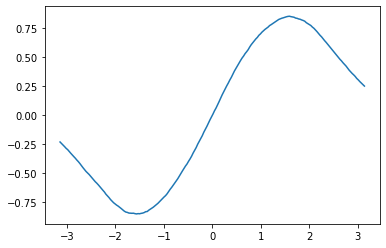

In [13]:
denoised_signal = convolve_gpu(noisy_signal, ma_filter)
plt.plot(t, denoised_signal)

Now it's time to benchmark the GPU implementation:

In [14]:
gpu_short_course.tests.benchmark_convolve(convolve_gpu, n=10)

Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0098 seconds (+/- 0.0007), median: 0.0095


The result will depend on the GPU device you have, but we think you should be able to notice some performance improvement :). 

The average processing time that you see above includes:
- the time required for memory allocations, data transfers from and to GPU device,
- the time required to execute the kernel code. 

Let's we use thhe CUDA profiler to get a bit more detail about the time it takes to complete each step:

In [15]:
%%writefile 2_1_2_convolve_gpu.py
import math
from numba import cuda, float32
import numpy as np
import gpu_short_course.tests
import cupy as cp

@cuda.jit
def convolve_gpu_kernel(y, x, h):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x

    M = len(x)
    N = len(h)
    o = int(math.ceil(N/2)-1)
    
    if i >= len(y):
        return
    
    # We explicitly cast the 0.0 value to float32, to be
    # sure we operate on 32-bit floating point numbers.
    value = float32(0.0)

    # Does the below looks familiar? 
    # It is almost copy-and-paste from the 
    # convolve_cpu function.
    for j in range(N):
        k = i + o - j
        if k >= 0 and k < M:
            value += x[k]*h[j]
    y[i] = value

def convolve_gpu(x, h):
    y = cuda.device_array(x.shape, dtype=x.dtype)
    block_size = 256
    grid_size = math.ceil(len(y)/block_size)
    convolve_gpu_kernel[grid_size, block_size](y, x, h)
    return y.copy_to_host()

gpu_short_course.tests.run_convolve(convolve_gpu)

Overwriting 2_1_2_convolve_gpu.py


In [16]:
! python 2_1_2_convolve_gpu.py --mode test
! nvprof --trace gpu python 2_1_2_convolve_gpu.py --mode benchmark n=10

GPU:0: b'Tesla T4'
All tests passed.
==834== NVPROF is profiling process 834, command: python3 2_1_2_convolve_gpu.py --mode benchmark n=10
GPU:0: b'Tesla T4'
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0596 seconds (+/- 0.1498), median: 0.0095
==834== Profiling application: python3 2_1_2_convolve_gpu.py --mode benchmark n=10
==834== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   73.70%  51.619ms        10  5.1619ms  5.1612ms  5.1632ms  cudapy::__main__::convolve_gpu_kernel$241(Array<float, int=1, C, mutable, aligned>, Array<float, int=1, C, mutable, aligned>, Array<float, int=1, C, mutable, aligned>)
                   16.21%  11.357ms        30  378.56us  1.9200us  1.1488ms  [CUDA memcpy DtoH]
                   10.08%  7.0624ms        20  353.12us  1.4720us  767.74us  [CUDA memcpy HtoD]
No API activities were profiled.


In the remainder of this notebook, we will focus primarily on the kernel execution time measured by the profiler, so we focus on optimizing minimizing the GPU kernel execution time. The `benchmark_convolve` function measures the execution time of the entire` convolve_gpu` function, which may also include the time needed to compile the GPU kernel, transfer data to and from GPU memory, etc. 

### Exercise 2.1.3. GPU global memory.

CUDA GPU global memory has the following advantages:
- GPU cards (usually) have a lot of global memory available,
- host PC can write data directly to it.

To check how much global GPU memory we have:

In [17]:
import cupy as cp

device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device name: {device_props['name']}")
print(f"Global memory: {device_props['totalGlobalMem']/2**20} [MiB]")

Device name: b'Tesla T4'
Global memory: 15109.75 [MiB]


The disadvantage of global memory is that it has quite huge latency in writing / reading data. Minimizing reads / writes from global memory is one way to improve the performance of our kernel.


Let's take another look at our convolution toy example:

```
x = [0, 1, 2, 3, 4]
h = [0, 1, 2]
```

```
y[0] = h[0]*x[1]+h[1]*x[0]           = 0
y[1] = h[0]*x[2]+h[1]*x[1]*h[2]*x[0] = 1
y[2] = h[0]*x[3]+h[1]*x[2]*h[2]*x[1] = 4
y[3] = h[0]*x[4]+h[1]*x[3]+h[2]*x[2] = 7
y[4] = h[1]*x[4]+h[2]*x[3]           = 10
```

For the above example, the `convolve_gpu`:
- reads `x[0]` and `x[4]`  from the global memory twice,
- reads `x[1]`, `x[2]` and `x[3]` three times.

Is there any possibility to implement a GPU kernel that reads the above data from global memory only once?


## Exercise 2.2. Shared memory.

The answer to previous question is: yes, using shared memory.

According to the [CUDA Toolkit documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html):
> (..) **shared memory** is expected to be a low-latency memory near each processor core (much like an L1 cache) (...)

>  **Shared memory** is expected to be much faster than global memory (...). It can be used as scratchpad memory (or software managed cache) to minimize global memory accesses from a CUDA block.

Shared memory has the following properties:
- the access time to the shared memory is much shorter than the access time to the global memory,
- it is usually much smaller than the global memory (the size of shared memory is usually counted in kilobytes, global memory -- in gigabytes),
- it's accessible only by CUDA kernel (i.e. it's not possible to write to/read from it directly from the host PC),
- it's content is local for each thread block, i.e. for each block of threads, there is a separate area of shared memory.



You can check the amout of shared memory available for each thread block available on your GPU by looking into device properties:

In [18]:
device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device name: {device_props['name']}")
print(f"Shared memory per thread block: {device_props['sharedMemPerBlock']} [bytes]")

Device name: b'Tesla T4'
Shared memory per thread block: 49152 [bytes]


A typical CUDA shared memory usage pattern is as follows:


- for each thread $i$ in a block:

  1. read data from the global to shared memory,
  2. wait until all threads in the block finish 1.,
  3. do calculations using data available in the shared memory.


We can apply the above pattern for the `convolve_gpu_kernel` implementation:

- let's declare that each block has shared memory for $B+N-1$ samples,
  - where: $B$ is the size of threads block, $N$ is the length of the filter, 
- for each thread $i$ in a block:

  1. read some portion of data from the global to shared memory,
    - start with $k = i+o-(N-1)$,

    - read from the global to shared memory: $x[k]$, $x[k+B]$, ..., and so on, until you hit the end of the shared memory area,
    - if $k + jB < 0$  for any $j$, write 0 to shared memory at position $i+jB$,
  2. wait until all threads in the block finish 1.,
  3. compute $y[i]$.

Let's try the above strategy with our toy convolution example. Assume, that $B = 5$.

```
x = [0, 1, 2, 3, 4]
h = [0, 1, 2]
shared_memory = [0, 0, 0, 0, 0, 0, 0]
```
(note: an unintialized shared memory may contain any arbitrary values, we used zeros just for the clarity).


Some remarks: 

- We have a one block, that computes all the output samples.
- $N = 3$
- $o = 1$

**Step 1. Read some portion of data from global memory to shared memory.**

Thread $i=0$:
```
0. start with k = 0 + 1 - (3-1) = -1
1. k     =-1; i     = 0 => shared_memory[0] <- 0
2. k + B = 4; i + B = 5 => shared_memory[5] <- x[4]
```

Thread $i=1$:
```
0. start with k = 0
1. k     = 0; i     = 1 => shared_memory[1] <- x[0],
2. k + B = 5; i + B = 6 => shared_memory[6] <- 0, 
```

Thread $i=2$:
```
0. start with k = 1
1. k     = 1; i     = 2 => shared_memory[2] <- x[1],
2. k + B = 6; i + B = 7 => STOP, 
```


Thread $i=3$:
```
0. start with k = 2
1. k     = 2; i     = 3 => shared_memory[3] <- x[2],
2. k + B = 7; i + B = 8 => STOP, 
```

Thread $i=4$:
```
0. start with k = 3
1. k     = 3; i     = 4 => shared_memory[4] <- x[3],
2. k + B = 8; i + B = 9 => STOP, 
```


**Step 2. Wait until threads finish the above procedure**.

At this point:

`shared_memory = [0, 0, 1, 2, 3, 4, 0]`

**Step 3. Compute $y$** 

```
 shared_memory = [0, 0, 1, 2, 3, 4, 0]      y = 
                 [2, 1, 0]                  [0 ]
                    [2, 1, 0]               [1 ]
                       [2, 1, 0]            [4 ]
                          [2, 1, 0]         [7 ]
                             [2, 1, 0]      [10]
```


Each `x[i]` was read exactly once.

Numba provides the following syntax for the shared memory area access:
- to *declare shared memory size*, pass the `shared_memory_size` (in **bytes**) to the kernel invocation line:
```
kernel[grid_size, block_size, stream, shared_memory_size](params)
```
- to access the shared memory within GPU kernel code, use `cuda.shared.array` function,
- to *wait until all threads in the block finish their job* use `cuda.syncthreads`. 

(see also the complete [documentation](https://numba.pydata.org/numba-doc/latest/cuda/memory.html#shared-memory-and-thread-synchronization))

Let's implement the above convolution algorithm with shared memory: 

In [19]:
%%writefile 2_2_convolve_shared_memory.py
import sys
import math
from numba import cuda, float32, int32
import cupy as cp
import gpu_short_course

device_props = cp.cuda.runtime.getDeviceProperties(0)

@cuda.jit
def convolve_gpu_kernel(y, x, h):
    # 0. INITIALIZATION.
    # The begining is very the same as previously.
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    if i >= y.shape[0]:
        return
    
    M, N = len(x), len(h)
    o = int(math.ceil(N/2)-1)
    shared_size = cuda.blockDim.x+N-1

    # Declare, that we want to use shared memory.
    # `shape=0` means: the size will be declared on kernel invocation.
    x_shared = cuda.shared.array(shape=0, dtype=float32)  

    # 1. READ DATA FROM GLOBAL TO SHARED MEMORY.
    k = i-(N-1)+o                   # The current position in the global memory.
    k_shared = cuda.threadIdx.x     # The current position in the shared memory.
    while k_shared < shared_size:   # Until we hit the end of the shared memory area.
        if k >= 0 and k < M:        
            x_shared[k_shared] = x[k]
        else:
            x_shared[k_shared] = float32(0.0)
        k_shared += cuda.blockDim.x
        k        += cuda.blockDim.x

    # 2. WAIT FOR THE OTHER THREADS FROM THE BLOCK.
    cuda.syncthreads()
    
    # 3. COMPUTE y[i]
    k_shared = cuda.threadIdx.x+N-1
    value = float32(0.0)
    for j in range(N):
        value += x_shared[k_shared-j]*h[j]
        
    y[i] = value
    

def convolve_gpu(x, h):
    y = cuda.device_array(x.shape, dtype=x.dtype)

    # 1. DEFINE HIERARCHY OF THREADS. 
    block_size = min(256, len(y))    
    grid_size = math.ceil(len(y)/block_size)

    # 2. DETERMINE, HOW MUCH SHARED MEMORY WE NEED?
    N = len(h)
    shared_size = block_size+N-1                     # Number of elements
    shared_size_bytes = shared_size*y.dtype.itemsize # Number of bytes
    # Make sure we not exceed the available shared memory size:
    if shared_size_bytes > device_props['sharedMemPerBlock']:    
        raise ValueError("Declared shared memory size exceeds the amount available for the device.")

    # 3. EXECUTE THE KERNEL.
    # Parameter `0` means "use default stream". 
    # We will describe CUDA streams in more detail in the future.
    convolve_gpu_kernel[grid_size, block_size, 0, shared_size_bytes](y, x, h)
    # 4. COPY THE RESULT TO HOST PC.
    return y.copy_to_host()

gpu_short_course.tests.run_convolve(convolve_gpu)

Overwriting 2_2_convolve_shared_memory.py


Let's test the implementation first:


In [20]:
! python 2_2_convolve_shared_memory.py --mode test

GPU:0: b'Tesla T4'
All tests passed.


In [21]:
! nvprof --trace gpu python 2_2_convolve_shared_memory.py --mode benchmark n=10

==869== NVPROF is profiling process 869, command: python3 2_2_convolve_shared_memory.py --mode benchmark n=10
GPU:0: b'Tesla T4'
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0640 seconds (+/- 0.1677), median: 0.0080
==869== Profiling application: python3 2_2_convolve_shared_memory.py --mode benchmark n=10
==869== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   66.90%  35.906ms        10  3.5906ms  3.5899ms  3.5912ms  cudapy::__main__::convolve_gpu_kernel$241(Array<float, int=1, C, mutable, aligned>, Array<float, int=1, C, mutable, aligned>, Array<float, int=1, C, mutable, aligned>)
                   19.77%  10.610ms        30  353.66us  2.1760us  1.0513ms  [CUDA memcpy DtoH]
                   13.33%  7.1561ms        20  357.81us  1.4720us  747.90us  [CUDA memcpy HtoD]
No API activities were profiled.


Compare the above result with that of a convolution from section 2.1.2.

## Exercise 2.3. Constant memory.

In our GPU convolution implementation, there is still one more array located in the global memory area, whose values are read over and over again -- the filter $h$ cofficients.

The filter coefficients, like the input samples, could be pre-read by each thread block to shared memory, similar to how we did with the input signal $x$ -- we leave the implementation of this to the student as homework. 

In this exercise, we will use another type of memory to store the filter coefficients: i.e., constant memory.

According to the [CUDA Toolkit documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html):

> (...) The constant memory space resides in device memory and is cached in the constant cache. (...)

> Constants are immutable and may not be modified from the device, even between parent and child launches. That is to say, the value of all __constant__ variables must be set from the host prior to launch. Constant memory is inherited automatically by all child kernels from their respective parents.

> An SM has:
a read-only constant cache that is shared by all functional units and speeds up reads from the constant memory space, which resides in device memory (...)

Constant memory has the following properties:
- it resides in global memory, and is access by a Multiprocessor via *constant cache*,
-  is read only,
- due to the limited size of constant cache, the available *constant memory* space is much smaller the available global memory,
- it can be accesed by CUDA kernel,
- it can be initialized by host code.


Let's we check the amout of constant memory available on our GPU:

In [22]:
device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device name: {device_props['name']}")
print(f"Constant memory size: {device_props['totalConstMem']} [bytes]")

Device name: b'Tesla T4'
Constant memory size: 65536 [bytes]


To use constant memory in Numba:
- prepare a `numpy` table, the contents of which should be copied to the GPU constant memory (`line 18`),
- get the handle to the persistent memory with the contents of the numpy array using the `numba.cuda.const.array_like` function (`line 29`).

In [23]:
%%writefile 2_3_convolve_const_memory.py

import sys
import math
from numba import cuda, float32, int32
import cupy as cp
import numpy as np
import gpu_short_course


mode = sys.argv[2]
if mode == "test":
    filter_size = 5
elif mode == "benchmark":
    filter_size = 256


# Allocate and fill the host PC array, the contents of which should be copied
# to the GPU constant memory.
h_host_const = np.random.rand(filter_size).astype(np.float32)


# We do not pass the filter `h` as a kernel parameter anymore.
@cuda.jit
def convolve_gpu_kernel(y, x):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    if i >= y.shape[0]:
        return
    
    # Allocate and prepare constant memory.
    h_gpu_const = cuda.const.array_like(h_host_const)

    M, N = len(x), len(h_gpu_const)
    o = int32(math.ceil(N/2)-1)
    
    x_shared = cuda.shared.array(shape=0, dtype=float32)
    shared_size = cuda.blockDim.x+N-1
    
    k = i+o-(N-1) 
    k_shared = cuda.threadIdx.x 
    while k_shared < shared_size:
        if k >= 0 and k < M:
            x_shared[k_shared] = x[k]
        else:
            x_shared[k_shared] = float32(0.0)
        k_shared += cuda.blockDim.x
        k        += cuda.blockDim.x

    cuda.syncthreads()
    
    k_shared = cuda.threadIdx.x+N-1
    value = float32(0.0)
    for j in range(N):
        value += x_shared[k_shared-j]*h_gpu_const[j]
        
    y[i] = value

    
def convolve_gpu(x):
    y = cuda.device_array(x.shape, dtype=x.dtype)
    block_size = min(256, len(y))
    grid_size = math.ceil(len(y)/block_size)
    N = len(h_host_const)
    shared_size = block_size+N-1
    shared_size_bytes = shared_size*y.dtype.itemsize
    convolve_gpu_kernel[grid_size, block_size, 0, shared_size_bytes](y, x)
    return y.copy_to_host()    

gpu_short_course.tests.run_convolve_const(convolve_gpu, h=h_host_const)

Overwriting 2_3_convolve_const_memory.py


In [24]:
! python 2_3_convolve_const_memory.py --mode test

GPU:0: b'Tesla T4'
All tests passed.


In [25]:
! nvprof --trace gpu python 2_3_convolve_const_memory.py --mode benchmark

==902== NVPROF is profiling process 902, command: python3 2_3_convolve_const_memory.py --mode benchmark
GPU:0: b'Tesla T4'
Benchmark result: 
Average processing time: 0.0137 seconds (+/- 0.0649), median: 0.0067
==902== Profiling application: python3 2_3_convolve_const_memory.py --mode benchmark
==902== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   61.38%  291.12ms       100  2.9112ms  2.9110ms  2.9119ms  cudapy::__main__::convolve_gpu_kernel$241(Array<float, int=1, C, mutable, aligned>, Array<float, int=1, C, mutable, aligned>)
                   23.42%  111.06ms       200  555.30us  367.49us  1.0899ms  [CUDA memcpy DtoH]
                   15.20%  72.097ms       100  720.97us  670.68us  905.18us  [CUDA memcpy HtoD]
No API activities were profiled.
